In [ ]:
"""
Overall summary of the API
1. Extract all faces in the image
2. Identify if each face has a mask or not
3. If not wearing a mask, verify age if mask is required
4. Draw box on faces labelling them whether "mask", "nomask" or "exempted"
"""

'\nOverall summary of the API\n1. Extract all faces in the image\n2. Identify if each face has a mask or not\n3. If not wearing a mask, verify age if mask is required\n4. Draw box on faces labelling them whether "mask", "nomask" or "exempted"\n'

In [ ]:
# Libraries and initial setup

In [ ]:
!pip3 install face_recognition
!pip install torch-mtcnn
!pip install py-agender[gpu]

In [ ]:
from google.colab import drive
# import face_recognition
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch_mtcnn import detect_faces
import torch.nn.functional as F
from torchvision import models
from PIL import Image
import torchvision.transforms as transforms
from torch.autograd import Variable
import matplotlib.patches as patches
import argparse
from google.colab.patches import cv2_imshow
from pyagender import PyAgender

torch.manual_seed(1) # set the random seed

Using TensorFlow backend.


In [ ]:
drive.mount('/content/drive')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/ipykernel/kernelbase.py", line 729, in _input_request
    ident, reply = self.session.recv(self.stdin_socket, 0)
  File "/usr/local/lib/python3.6/dist-packages/jupyter_client/session.py", line 803, in recv
    msg_list = socket.recv_multipart(mode, copy=copy)
  File "/usr/local/lib/python3.6/dist-packages/zmq/sugar/socket.py", line 566, in recv_multipart
    parts = [self.recv(flags, copy=copy, track=track)]
  File "zmq/backend/cython/socket.pyx", line 783, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 819, in zmq.backend.cython.socket.Socket.recv
  File "zmq/backend/cython/socket.pyx", line 186, in zmq.backend.cython.socket._recv_copy
  File "zmq/backend/cython/checkrc.pxd", line 13, in zmq.backend.cython.checkrc._check_rc
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/li

TypeError: ignored

In [ ]:
# Useful paths

In [ ]:
temp_path = '/content/drive/My Drive/Colab Notebooks/Project/demo_images/temp/'
savedmodel_path = '/content/drive/My Drive/Colab Notebooks/Project/demo_images/saved_model/'
image_path = '/content/drive/My Drive/Colab Notebooks/Project/demo_images/images/'

In [ ]:
!cd '/content/drive/My Drive/Colab Notebooks/Project/demo_images/images/' && ls -la

total 2038
-rw------- 1 root root 282996 Dec  3 16:43 test10.jpg
-rw------- 1 root root 117711 Dec  3 16:43 test11.jpg
-rw------- 1 root root 562813 Dec  6 12:14 test12.jpg
-rw------- 1 root root 146646 Nov 28 14:56 test1.jpg
-rw------- 1 root root  64558 Nov 28 15:19 test2.jpg
-rw------- 1 root root 107909 Nov 28 15:19 test3.jpg
-rw------- 1 root root  28568 Nov 28 17:38 test4.jpg
-rw------- 1 root root 119897 Nov 28 17:41 test5.jpg
-rw------- 1 root root  61759 Dec  3 16:43 test6.jpg
-rw------- 1 root root 236274 Dec  3 16:43 test7.jpg
-rw------- 1 root root 151294 Dec  3 16:43 test8.jpg
-rw------- 1 root root 203421 Dec  3 16:43 test9.jpg


In [ ]:
!cd '/content/drive/My Drive/Colab Notebooks/Project/demo_images/saved_model/' && ls -la

total 47052
-rw------- 1 root root 21004567 Nov 28 13:48 model_MaskNet1_withAug_bs128_lr0.001_epoch5.zip
-rw------- 1 root root 21004551 Nov 28 13:48 model_MaskNet_aug_bs128_lr0.001_epoch10.zip
-rw------- 1 root root  2061755 Nov 28 13:48 model_Transfer_Learning_aug_dropout_bs128_lr0.001_epoch25.zip
-rw------- 1 root root  4109763 Nov 28 13:48 model_TransferLearning_GoogleNet_bs128_lr0.001_epoch10.zip


In [ ]:
# Initializations

In [ ]:
#The CNN Network
class MaskNet(nn.Module):
    def __init__(self):
        super(MaskNet, self).__init__()
        self.name = "large"
        self.conv1 = nn.Conv2d(1, 20, kernel_size=3,stride=1,padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.conv2 = nn.Conv2d(20,40 , kernel_size=3,stride=1,padding=1)
        # self.pool = nn.MaxPool2d(kernel_size=2, stride=2,padding=0)
        self.fc1 = nn.Linear(64 * 64 * 40, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = (F.relu(self.conv1(x.float())))
        x = self.pool(x)
        x = F.relu(self.conv2(x.float()))
        x = x.view(-1, 40 * 64* 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1) # Flatten to [batch_size]
        return  x

In [ ]:
saved_model = MaskNet()
# saved_model.load_state_dict((torch.load(savedmodel_path + 'model_MaskNet_aug_rot_bs128_lr0.001_epoch14', map_location=torch.device('cpu'))))
saved_model.load_state_dict((torch.load(savedmodel_path + 'model_MaskNet1_withAug_bs128_lr0.001_epoch5.zip', map_location=torch.device('cpu'))))
saved_model.eval() # MUST TO REMOVE DROPOUT
if torch.cuda.is_available():
  saved_model=saved_model.cuda() # GPU 

NameError: ignored

In [ ]:
agender = PyAgender()

In [ ]:
# API Functions

In [ ]:
# Output from our model

In [ ]:
def model_output(image):
    # # Initiate all the necessary models
    # saved_model = Classifier_withDropout() # INSTANTIATE
    # saved_model.load_state_dict((torch.load(savedmodel_path + 'model_TransferLearning_GoogleNet_bs128_lr0.001_epoch10')))#LOAD
    # saved_model.eval() # MUST TO REMOVE DROPOUT
    # saved_model=saved_model.cuda() # GPU 
    
    # Load the single face image
    transform = transforms.Compose([transforms.Resize((128,128)), transforms.Grayscale(),transforms.ToTensor()])
    
    image = transform(image).float()
    image = Variable(image, requires_grad=True)
    if torch.cuda.is_available():
      image.cuda()
    image = image.unsqueeze(0)

    # Use our model to identify the image
    output = saved_model(image)
    pred = output.max(1, keepdim=True)[1]

    if(pred==0):
      return "mask"
    else:
      return "nomask"

In [ ]:
# Age Detection API. Accepts OpenCV image only
def age_detection_api(image):
    faces = agender.detect_genders_ages(image)
    if len(faces) > 0:
      age = int(round(faces[0]["age"]) - 1) 
    else:
      age = -1  
    #add extra stuff here
    if age < 16 and age > 5:
       age = age - 5   
    return age


In [ ]:
# API definition

In [ ]:
def mask_detection_api(img_path):
    
    # Reading image
    img = Image.open(img_path)
    # img2 = cv2.imread(img_path)

    # Identifying all the faces
    bounding_boxes, landmarks = detect_faces(img)

    # img = cv2.imread(img_path)
    fig,ax = plt.subplots(1)
    ax.imshow(img)

    # Mask detection for each face
    count = 0
    for i in range (len(bounding_boxes)):
      xmin = int(bounding_boxes[i][0])
      ymin = int(bounding_boxes[i][1])
      xmax = int(bounding_boxes[i][2])
      ymax = int(bounding_boxes[i][3])

      # print("face", i, ":", bounding_boxes)
      face_image = img.crop((xmin, ymin, xmax, ymax))
      width, height = face_image.size
      count += 1
      result = model_output(face_image)

      x_increase = (xmax - xmin)*0.4
      y_increase = (ymax - ymin)*0.4

      if (result == "mask"):
        # draw green box and write mask
        # print("Face", count, "- mask detected")
        rect = patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='g', facecolor='none')
        plt.text(xmin, ymin-y_increase*0.15, "mask", fontsize=8, color="green")
        ax.add_patch(rect)

      else:
        # check age
        img_cropped = img.crop((xmin-x_increase, ymin-y_increase, xmax+x_increase, ymax+y_increase))
        open_cv_image = np.array(img_cropped) 
        open_cv_image = open_cv_image[:, :, ::-1].copy()    
        
        age = age_detection_api(open_cv_image)
        
        ageClassOutput = ""
        ageMessage = ""

        if age==-1:
          # print("Face", count, "- nomask detected - AGE NOT DETECTED")
          rect = patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
          plt.text(xmin, ymin-y_increase*0.15, "no mask", fontsize=8, color="red")
          ax.add_patch(rect)   
        else:
          if (age < 11):
            # print("Face", count, "- exempted - age:", age)
            rect = patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='g', facecolor='none')
            plt.text(xmin, ymin-y_increase*0.15, "exempted", fontsize=8, color="green")
            ax.add_patch(rect)
          else:
            # print("Face", count, "- nomask detected - age:", age)
            rect = patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
            plt.text(xmin, ymin-y_increase*0.15, "no mask", fontsize=8, color="red")
            ax.add_patch(rect)

    if (count == 0):
      print("No face detected")

    else:
      print("Faces highlighted in the image")

In [ ]:
# # OLD code
#         # check age
#         # draw green box and write exempted or draw red box and write no-mask
        
#         print("Face", count, "- nomask detected")
#         rect = patches.Rectangle((xmin,ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
#         plt.text(xmin, ymin-y_increase*0.15, "no mask", fontsize=8, color="red")
#         ax.add_patch(rect)
        

#         # # Age detection stuff
#         # fix = (height+width)/2
#         # fix = int(fix)
#         # img_temp = img2[ymin-fix:ymax+fix, xmin-fix:xmax+fix]
#         # faces = agender.detect_genders_ages(img2)
#         # # age = int(round(faces[0]["age"]) - 1)
#         # # age = faces[0]["age"]
#         # print(faces)

#         img_cropped = img.crop((xmin-x_increase, ymin-y_increase, xmax+x_increase, ymax+y_increase))
#         open_cv_image = np.array(img_cropped) 
#         open_cv_image = open_cv_image[:, :, ::-1].copy()    
#         age = age_detection_api(open_cv_image)
#         ageClassOutput = ""
#         ageMessage = ""
#         if age==-1:
#           #ageClassOutput = "Age could not be determined"
#           ageClassOutput = ""
#         else:
#           print("Age is: ", age)
#           if (age < 6):
#             ageClassOutput = "Age range: 0 - 5" 
#             ageMessage = "Mask not required"
#           elif (age < 12):
#             ageClassOutput = "Age range: 6 - 11"
#             ageMessage = "Mask not required but recommended"
#           elif (age < 60):
#             ageClassOutput = "Age range: 12 - 59"
#             ageMessage = "Mask is required"
#           else:
#             ageClassOutput = "Age range: 6 - 11"
#             ageMessage = "Mask is required and strongly encouraged due to high risk"
#         plt.text(xmin, ymax+y_increase*0.25, ageClassOutput, fontsize=8, color="red")
#         plt.text(xmin, ymax+y_increase*0.45, ageMessage, fontsize=8, color="red")


Downloading: "https://github.com/khrlimam/mtcnn-pytorch/releases/download/0.0.1/pnet-6b6ef92b.pth" to /root/.cache/torch/hub/checkpoints/pnet-6b6ef92b.pth


Downloading: "https://github.com/khrlimam/mtcnn-pytorch/releases/download/0.0.1/rnet-b13c48bc.pth" to /root/.cache/torch/hub/checkpoints/rnet-b13c48bc.pth


Downloading: "https://github.com/khrlimam/mtcnn-pytorch/releases/download/0.0.1/onet-60cc8dd5.pth" to /root/.cache/torch/hub/checkpoints/onet-60cc8dd5.pth



Faces highlighted in the image


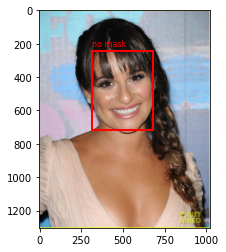

In [ ]:
mask_detection_api(image_path + 'test1.jpg')

Faces highlighted in the image


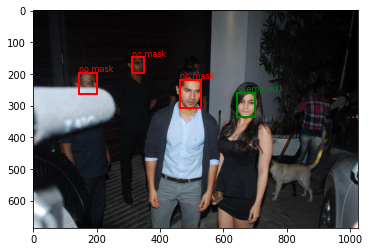

In [ ]:
mask_detection_api(image_path + 'test2.jpg')

Faces highlighted in the image


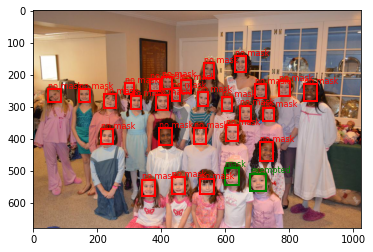

In [ ]:
mask_detection_api(image_path + 'test3.jpg')

Faces highlighted in the image


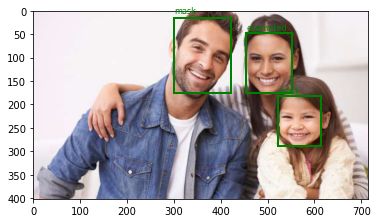

In [ ]:
mask_detection_api(image_path + 'test4.jpg')

Faces highlighted in the image


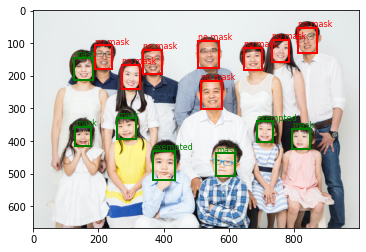

In [ ]:
mask_detection_api(image_path + 'test5.jpg')

Faces highlighted in the image


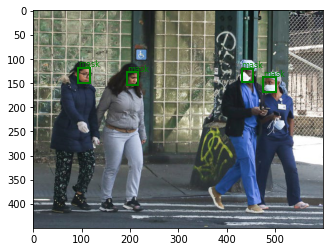

In [ ]:
mask_detection_api(image_path + 'test6.jpg')

Faces highlighted in the image


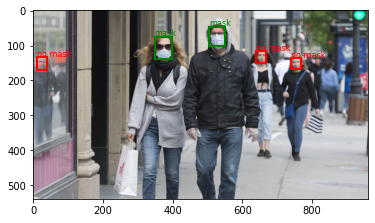

In [ ]:
mask_detection_api(image_path + 'test7.jpg')

Faces highlighted in the image


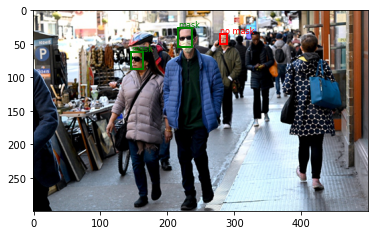

In [ ]:
mask_detection_api(image_path + 'test8.jpg')

Faces highlighted in the image


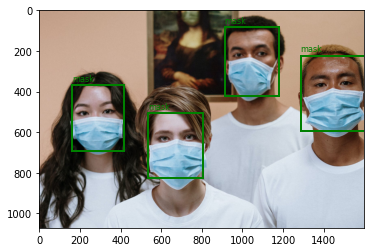

In [ ]:
mask_detection_api(image_path + 'test9.jpg')

Faces highlighted in the image


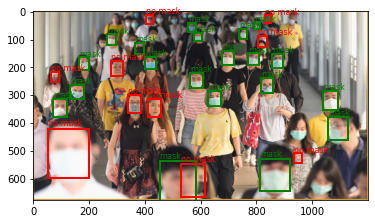

In [ ]:
mask_detection_api(image_path + 'test10.jpg')

In [ ]:
# DEMO beyond this

In [ ]:
!cd '/content/drive/My Drive/Colab Notebooks/Project/demo_images/images/' && ls -la

total 2434
-rw------- 1 root root 282996 Dec  3 16:43 test10.jpg
-rw------- 1 root root 117711 Dec  3 16:43 test11.jpg
-rw------- 1 root root 562813 Dec  6 12:14 test12.jpg
-rw------- 1 root root 166397 Dec  6 12:17 test13.jpg
-rw------- 1 root root 238662 Dec  6 12:19 test14.jpg
-rw------- 1 root root 146646 Nov 28 14:56 test1.jpg
-rw------- 1 root root  64558 Nov 28 15:19 test2.jpg
-rw------- 1 root root 107909 Nov 28 15:19 test3.jpg
-rw------- 1 root root  28568 Nov 28 17:38 test4.jpg
-rw------- 1 root root 119897 Nov 28 17:41 test5.jpg
-rw------- 1 root root  61759 Dec  3 16:43 test6.jpg
-rw------- 1 root root 236274 Dec  3 16:43 test7.jpg
-rw------- 1 root root 151294 Dec  3 16:43 test8.jpg
-rw------- 1 root root 203421 Dec  3 16:43 test9.jpg


Faces highlighted in the image


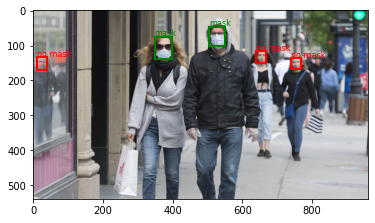

In [ ]:
mask_detection_api(image_path + 'test7.jpg')

Faces highlighted in the image


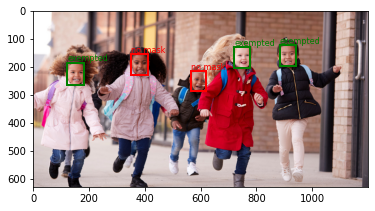

In [ ]:
mask_detection_api(image_path + 'test13.jpg')

Faces highlighted in the image


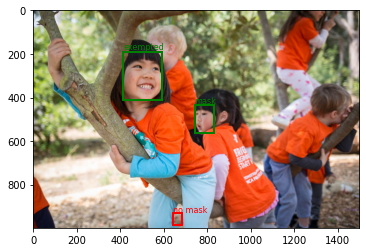

In [ ]:
mask_detection_api(image_path + 'test13.jpg')

Faces highlighted in the image


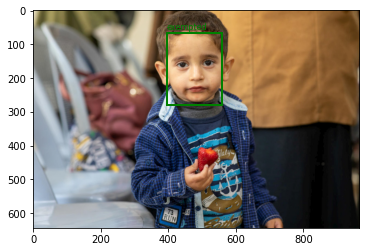

In [ ]:
mask_detection_api(image_path + 'test14.jpg')

In [ ]:
"""
DEMO
DEMO
DEMO
DEMO
DEMO
DEMO
DEMO
DEMO
DEMO
"""

Faces highlighted in the image


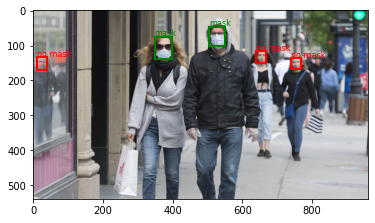

In [ ]:
mask_detection_api(image_path + 'test7.jpg')

Faces highlighted in the image


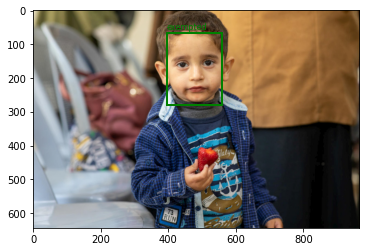

In [ ]:
mask_detection_api(image_path + 'test14.jpg')

In [ ]:
image_path = '/content/drive/My Drive/APS360/Project Files/'

6 year old girl not wearing mask

Faces highlighted in the image


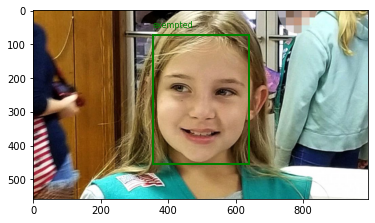

In [ ]:
mask_detection_api(image_path + 'youth1.jpg')

Group of seniors without wearing masks

In [ ]:
mask_detection_api(image_path + 'seniors.jpg')

FileNotFoundError: ignored

Image including mask and non-mask wearers

Faces highlighted in the image


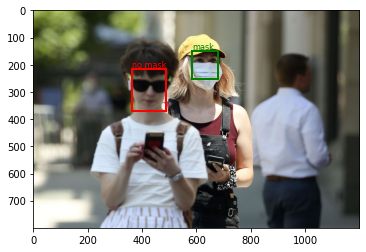

In [ ]:
mask_detection_api(image_path + 'crowd1.jpg')